## Problem 3: 

#### Produce random points following $h(x) \sim \exp(-x/3)\cos(x)^2$ in the interval $[0, \infty]$ and estimate the integral of $h(x)$ in the defined range.

*Solution Example to Problem 3*:<br>

This is a harder problem than the two above. The function can neither be integrated and then inverted nor bounded in $x$. Therefore, one has to combine the two methods. First, we want to generate numbers according to __"a smart box"__, i.e. with a function that covers $h(x)$, i.e. is always greater than $h(x)$ and can be produced using the transformation method. In our case, the exponential function $k(x) = 1/3 \exp(-x/3)$ serves the purpose very well.

We thus draw $x$-values from $k(x)$ (transformation method) and accept the $x$-value if a random value $y$ (chosen between 0 and $k(x)$ falls below the functional value of $h(x)$ at the chosen $x$-value (accept/reject).

In [41]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.stats import binom, poisson, norm           # Functions from SciPy Stats...
# import scipy.optimize as optimization
from scipy import optimize
from numpy.linalg import inv
from functools import partial
from fitter import Fitter
from astropy.modeling import models, fitting

In [42]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [43]:
r = np.random
r.seed(42)

save_plots = False  
N_points = 10000    # Number

In [44]:
x_exp1 = -0.8*np.log(r.uniform(size=N_points))
x_exp2 = -0.8*np.log(r.uniform(size=N_points))
x_exp3 = -0.8*np.log(r.uniform(size=N_points))
x_exp4 = -0.8*np.log(r.uniform(size=N_points))
x_expsum = x_exp1 + x_exp2 + x_exp3 + x_exp4

0.2


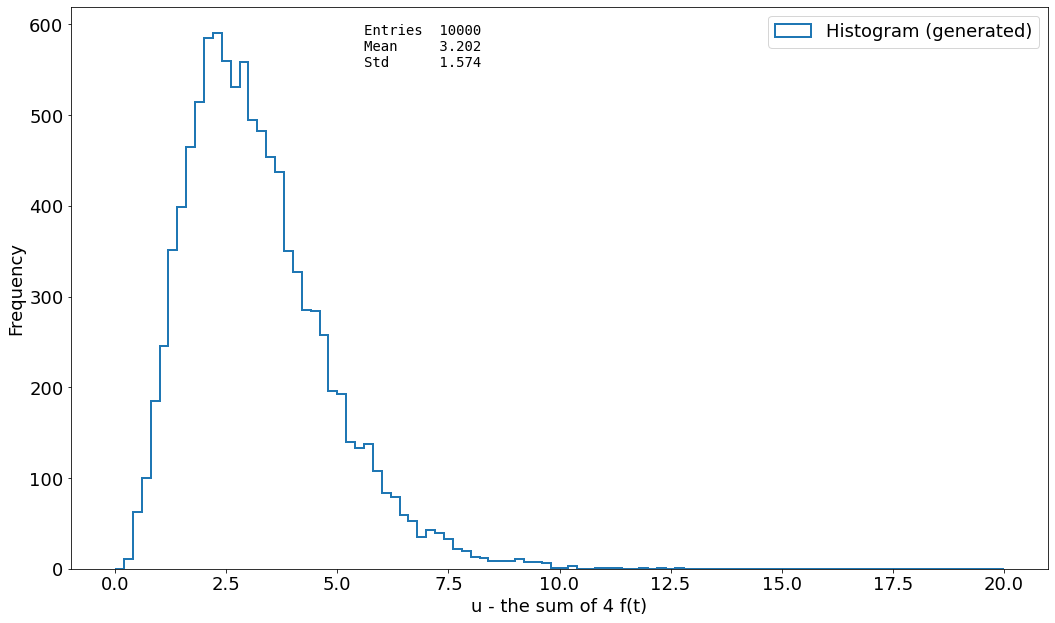

In [45]:

# f(x)
def exp_func(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / Nbins
    N = N_points * k
    return N * 1/0.8 * np.exp(-x/0.8)

# Define a reasonable range to plot in:
xmin = 0
xmax = 20
Nbins = 100
binwidth = (xmax - xmin) / Nbins
print(binwidth)


# plot sum
fig, ax = plt.subplots(figsize=(15, 9))
ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2,label='Histogram (generated)' )
ax.set(xlabel="u - the sum of 4 f(t)", ylabel="Frequency", xlim=(xmin-1.0, xmax+1.0)) # 不知道为什么原来是"Frequency / 0.2"

# Plot f(x)
x_axis1 = np.linspace(xmin, xmax, 1000)
y_axis1 = exp_func(x_axis1)
#ax.plot(x_axis1, y_axis1, 'r-', label='Function (not fitted)')

# Define figure text
d = {'Entries': len(x_expsum),
     'Mean': x_expsum.mean(),
     'Std': x_expsum.std(ddof=1),
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.3, 0.97, text, ax, fontsize=14)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

# Save figure
fig.savefig("HistAndFunc_exp.png", dpi=600)

In [46]:

# 朴素计算10000个点的mu和sigma
mu = np.sum(x_expsum)/N_points
mu_array = np.ones_like(x_expsum) * mu
a = np.zeros_like(x_expsum)
a_sum = float

for i in range(0,10000):
    a[i] = (x_expsum[i] - mu_array[i])**2
    
a_sum = np.sum(a)
sigma = np.sqrt(a_sum/N_points)
print(mu)
print(sigma)


3.2017026139636466
1.5741536459636298


57 57 57


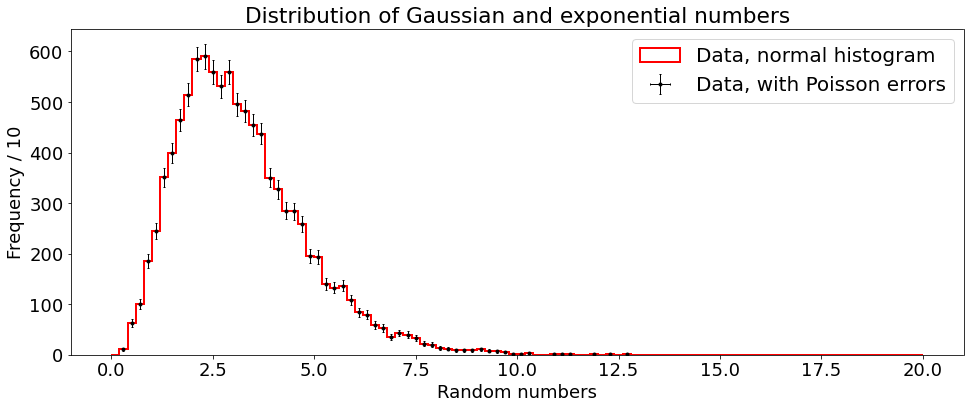

In [47]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
hist = ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Data, normal histogram')

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_expsum, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0]+ bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts)[counts>0]  # NOTE: We (naturally) assume that the bin count is Poisson distributed. 不能为0
# 分母不能为0 如果有必要，可以添加：[counts>0]
# This is an approximation, since there is a low count in the last bins.
print(x.size,y.size,sy.size)

ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Random numbers",           # the label of the y axis
       ylabel="Frequency / 10",           # the label of the y axis
       title="Distribution of Gaussian and exponential numbers")    # the title of the plot
ax.legend(loc='best', fontsize=20);       # could also be # loc = 'upper right' e.g.

In [48]:

# 快速计算高斯拟合mean,error的方法
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
print(g.mean.value, g.stddev.value)
# 2.802265163442513 1.3973229547835018


2.7942487087845698 1.4190239165892131


In [49]:
'''
print(x,y,sy)
print(x.size,y.size,sy.size)
'''

'\nprint(x,y,sy)\nprint(x.size,y.size,sy.size)\n'

In [50]:
N_fit = binwidth*100*x.size
print(N_fit)

1140.0


In [51]:
# Define your PDF / model 
def fit_pdf(x,a,b,c):
    """Gamma Distribution"""
    return a*(x**b)*np.exp(-c*x)    # 第一项为N*binwidth，手动加进去了


In [52]:

Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(a,b,c) :
    y_fit = fit_pdf(x,a,b,c)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf,x,y,sy)

minuit_chi2 = Minuit(chi2_owncalc,a=2,b=2,c=2)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.67                      │              Nfcn = 343              │
│ EDM = 3.82e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    813    │    19     │            │            │         │         │       │
│ 1 │ b    │   3.16    │   0.06    │            │            │         │         │       │
│ 2 │ c    │   1.303   │   0.020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │      347  -0.0932   0.0782 │
│ b │  -0.0932  0.00341  0.00107 │
│ c │   0.0782  0.00107 0.000379 │
└───┴────────────────────────────┘

In [53]:

# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_a,fit_b,fit_c= minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")


Fit value: a = 812.87781 +/- 18.63964
Fit value: b = 3.16217 +/- 0.05843
Fit value: c = 1.30345 +/- 0.01946
Chi2 value: 47.7   Ndof = 54    Prob(Chi2,Ndof) = 0.715


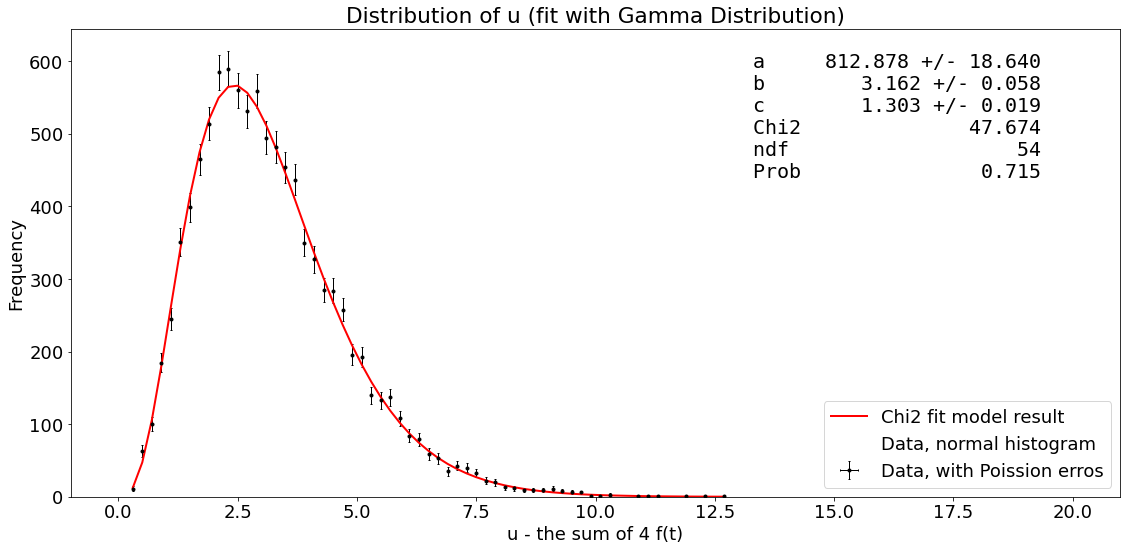

In [54]:

fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
hist = ax.hist(x_expsum, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=0,  label='Data, normal histogram')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poission erros', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="u - the sum of 4 f(t)", # the label of the y axis
       ylabel="Frequency",  # the label of the y axis
       title="Distribution of u (fit with Gamma Distribution)", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero


# Adding fit function to plot:
ax.plot(x, fit_pdf(x=x,a=minuit_chi2.values['a'],b=minuit_chi2.values['b'],c=minuit_chi2.values['c']), '-r', linewidth=2, label='Chi2 fit model result')   #0.55168


# Adding fit results to plot:
d = {'a': [minuit_chi2.values['a'], minuit_chi2.errors['a']],
     'b': [minuit_chi2.values['b'], minuit_chi2.errors['b']],
     'c': [minuit_chi2.values['c'], minuit_chi2.errors['c']],
 #    'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower right', fontsize=18); # could also be # loc = 'upper right' e.g.

fig.tight_layout()
plt.savefig('fig5',dpi=600)
